In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
def sample_data_1():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + rand.randn(count, 2) * [[5.0, 1.0]]

def sample_data_2():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + (rand.randn(count, 2) * [[5.0, 1.0]]).dot(
    [[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]])

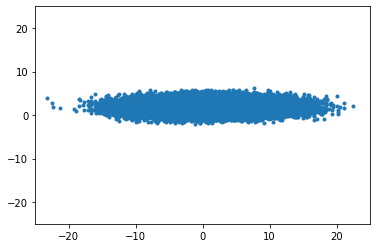

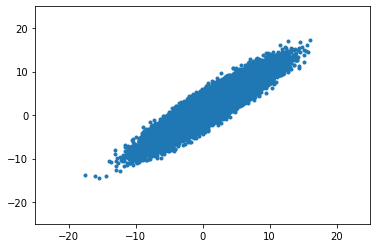

In [3]:
data1 = sample_data_1().astype(np.float32)
plt.figure()
plt.plot(data1[:,0], data1[:,1], '.')
plt.axis((-25,25,-25,25))

data2 = sample_data_2().astype(np.float32)
plt.figure()
plt.plot(data2[:,0], data2[:,1], '.')
_ = plt.axis((-25,25,-25,25))

In [4]:
def softlimit(x, limit=0.1):
    return tf.math.log(tf.math.exp(x) + 1.0 + limit)

def dense(x, nrof_units, activation=None, training=True, use_batch_norm=False):
    x = tf.compat.v1.layers.Flatten()(x)
    x = tf.compat.v1.layers.Dense(units=nrof_units)(x)
    if use_batch_norm:
        x = tf.compat.v1.layers.BatchNormalization()(x, training=training)
    x = x if activation is None else activation(x)
    return x

def mlp(x, nrof_units, activation, nrof_layers=1, training=True):
    for _ in range(nrof_layers):
        x = dense(x, nrof_units=nrof_units, activation=activation, training=training)
    return x

def sample(mu, sigma):
    epsilon = tf.random.normal(tf.shape(mu), mean=0.0, stddev=1.0)
    return mu + sigma*epsilon

def log_normal(x, mean, log_var, eps=1e-5):
    c = - 0.5 * np.log(2*np.pi)
    return c - log_var/2 - (x - mean)**2 / (2 * tf.math.exp(log_var) + eps)

In [5]:
def vae(x, temp, nrof_mlp_units, nrof_stochastic_units, nrof_layers, use_scalar_sigma, is_training):
    dbg = dict()
    
    dbg['x'] = x
    h = x
    h = mlp(h, nrof_mlp_units, activation=tf.nn.leaky_relu, nrof_layers=nrof_layers, training=is_training)
    q_mu = dense(h, nrof_stochastic_units, training=is_training)
    if use_scalar_sigma:
        s = dense(h, 1, activation=softlimit, training=is_training)
        q_sigma = tf.ones_like(q_mu) * s
    else:
        q_sigma = dense(h, nrof_stochastic_units, activation=softlimit, training=is_training)
    dbg['q_mu'] = q_mu
    dbg['q_sigma'] = q_sigma

    z = sample(q_mu, q_sigma)
    dbg['z'] = z
    
    h = mlp(z, nrof_mlp_units, activation=tf.nn.leaky_relu, nrof_layers=nrof_layers, training=is_training)
    x_rec_mu = dense(h, nrof_stochastic_units, training=is_training)
    x_rec_sigma = dense(h, nrof_stochastic_units, activation=softlimit, training=is_training)
    dbg['x_rec_mu'] = x_rec_mu
    dbg['x_rec_sigma'] = x_rec_sigma
    dbg['x_sample'] = sample(x_rec_mu, x_rec_sigma)

    log_pxz = log_normal(x, x_rec_mu, tf.math.log(x_rec_sigma)*2)
    dbg['log_pxz'] = tf.reduce_mean(log_pxz)

    p_mu, p_sigma = tf.zeros_like(q_mu), tf.ones_like(q_sigma)
    log_qz = log_normal(z, q_mu, tf.math.log(q_sigma)*2)
    log_pz = log_normal(z, p_mu, tf.math.log(p_sigma)*2)
    dbg['log_pzx'] = tf.reduce_mean(log_pz - log_qz)
    
    elbo = tf.reduce_mean(log_pxz + temp*(log_pz - log_qz))
    dbg['elbo'] = elbo
    loss = -elbo

    return loss, dbg


In [6]:
def create_dataset(x, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(x)
    dataset = dataset.repeat()   # Repeat the dataset indefinitely
    dataset = dataset.shuffle(10000)   # Shuffle the data
    dataset = dataset.batch(batch_size)  # Create batches of data
    dataset = dataset.prefetch(batch_size)  # Prefetch data for faster consumption
    iterator = tf.compat.v1.data.make_initializable_iterator(dataset)  # Create an iterator over the dataset
    return iterator

In [7]:
def get_warmup_temp(epoch, nrof_warmup_epochs):
    if nrof_warmup_epochs>0:
        temp = np.minimum(1.0, 1.0/nrof_warmup_epochs * epoch)
    else:
        temp = 1.0
    return temp

In [8]:
def train_vae(data, use_scalar_sigma):
    nrof_epochs = 10
    batch_size = 100
    nrof_stochastic_units = 2
    nrof_mlp_units = 50
    nrof_layers = 5
    nrof_warmup_epochs = 5

    tf.reset_default_graph()
    with tf.Graph().as_default():
        train_iterator = create_dataset(data, batch_size)
        eval_input_ph = tf.placeholder(tf.float32, shape=(None, 2))
        temp_ph = tf.placeholder(tf.float32, shape=())

        with tf.compat.v1.variable_scope('model', reuse=False):
            train_loss, train_dbg = vae(train_iterator.get_next(), temp_ph, nrof_mlp_units=nrof_mlp_units,  
                nrof_stochastic_units=nrof_stochastic_units, nrof_layers=nrof_layers, use_scalar_sigma=use_scalar_sigma,
                is_training=True)
        with tf.compat.v1.variable_scope('model', reuse=True):
            eval_loss, eval_dbg = vae(eval_input_ph, temp_ph, nrof_mlp_units=nrof_mlp_units, 
                nrof_stochastic_units=nrof_stochastic_units, nrof_layers=nrof_layers, use_scalar_sigma=use_scalar_sigma,
                is_training=False)

        optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
        train_op = optimizer.minimize(train_loss)

        sess = tf.compat.v1.InteractiveSession()
        sess.run(tf.compat.v1.global_variables_initializer())
        sess.run(train_iterator.initializer)

        nrof_batches = data.shape[0] // batch_size

        loss_list = []
        elbo_list = []
        log_pxz_list = []
        log_pzx_list = []
        for epoch in range(1, nrof_epochs+1):
            temp = get_warmup_temp(epoch, nrof_warmup_epochs)
            for i in range(nrof_batches):
                _, loss_, train_dbg_ = sess.run([train_op, train_loss, train_dbg], feed_dict={temp_ph:temp})
                loss_list += [ loss_ ]
                elbo_list += [ train_dbg_['elbo'] ]
                log_pxz_list += [ train_dbg_['log_pxz'] ]
                log_pzx_list += [ train_dbg_['log_pzx'] ]
            print('train epoch: %4d  temp: %7.3f  loss: %7.3f  p(x|z): %7.3f  p(z|x): %7.3f' % (
                epoch, temp, loss_, train_dbg_['log_pxz'], train_dbg_['log_pzx']))
            
    plt.plot(elbo_list)
    plt.plot(log_pxz_list)
    plt.plot(log_pzx_list)
    plt.ylim((-5.0,1.0))
    plt.title('Training loss')
    plt.xlabel('Training step')
    _ = plt.ylabel('Negative Log Likelihood')

    nsamp = 100000
    z = np.random.randn(nsamp,2)
    dbg_ = sess.run(eval_dbg, feed_dict={eval_input_ph:np.zeros((nsamp,2)), eval_dbg['z']:z, temp_ph:temp})
    print('x mean: ', np.mean(dbg_['x_sample'], axis=0))
    print('x std: ', np.std(dbg_['x_sample'], axis=0))
    plt.figure()
    plt.plot(dbg_['x_sample'][:,0], dbg_['x_sample'][:,1], 'b.')
    plt.plot(dbg_['x_rec_mu'][:,0], dbg_['x_rec_mu'][:,1], 'r.')
    plt.axis((-25,25,-25,25))

    dbg_ = sess.run(eval_dbg, feed_dict={eval_input_ph:data, temp_ph:1.0})
    print('z mean: ', np.mean(dbg_['z'], axis=0))
    print('z std: ', np.std(dbg_['z'], axis=0))
    plt.figure()
    plt.plot(dbg_['z'][:,0], dbg_['z'][:,1], '.')
    plt.axis((-5,5,-5,5))

# Dataset 1, diagonal standard deviation

W1004 23:15:39.212250 140089029125952 deprecation.py:506] From /home/david/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1004 23:15:39.761506 140089029125952 deprecation.py:323] From /home/david/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


train epoch:    1  temp:   0.200  loss:   1.751  p(x|z):  -1.473  p(z|x):  -1.393
train epoch:    2  temp:   0.400  loss:   1.972  p(x|z):  -1.427  p(z|x):  -1.364
train epoch:    3  temp:   0.600  loss:   1.941  p(x|z):  -1.260  p(z|x):  -1.134
train epoch:    4  temp:   0.800  loss:   2.062  p(x|z):  -1.055  p(z|x):  -1.258
train epoch:    5  temp:   1.000  loss:   2.272  p(x|z):  -1.085  p(z|x):  -1.187
train epoch:    6  temp:   1.000  loss:   2.194  p(x|z):  -1.070  p(z|x):  -1.125
train epoch:    7  temp:   1.000  loss:   2.214  p(x|z):  -1.102  p(z|x):  -1.112
train epoch:    8  temp:   1.000  loss:   2.235  p(x|z):  -1.102  p(z|x):  -1.133
train epoch:    9  temp:   1.000  loss:   2.431  p(x|z):  -1.203  p(z|x):  -1.228
train epoch:   10  temp:   1.000  loss:   2.222  p(x|z):  -1.064  p(z|x):  -1.158
x mean:  [0.9395751 1.9921106]
x std:  [5.0656366 1.0196393]
z mean:  [0.02444003 0.00431168]
z std:  [0.98169875 0.9899922 ]


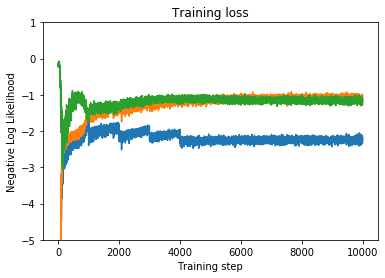

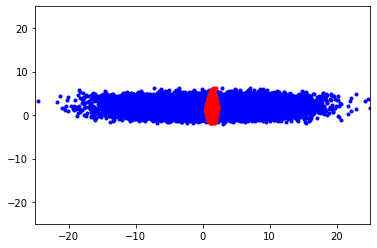

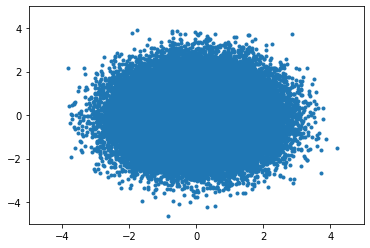

In [9]:
train_vae(data1, use_scalar_sigma=False)

# Dataset 1, scalar standard deviation

/home/david/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


train epoch:    1  temp:   0.200  loss:   2.220  p(x|z):  -2.106  p(z|x):  -0.569
train epoch:    2  temp:   0.400  loss:   2.189  p(x|z):  -2.109  p(z|x):  -0.202
train epoch:    3  temp:   0.600  loss:   2.109  p(x|z):  -1.904  p(z|x):  -0.341
train epoch:    4  temp:   0.800  loss:   2.140  p(x|z):  -1.942  p(z|x):  -0.248
train epoch:    5  temp:   1.000  loss:   2.150  p(x|z):  -2.115  p(z|x):  -0.035
train epoch:    6  temp:   1.000  loss:   2.218  p(x|z):  -2.185  p(z|x):  -0.034
train epoch:    7  temp:   1.000  loss:   2.292  p(x|z):  -2.281  p(z|x):  -0.010
train epoch:    8  temp:   1.000  loss:   2.215  p(x|z):  -2.195  p(z|x):  -0.020
train epoch:    9  temp:   1.000  loss:   2.267  p(x|z):  -2.291  p(z|x):   0.024
train epoch:   10  temp:   1.000  loss:   2.227  p(x|z):  -2.224  p(z|x):  -0.003
x mean:  [1.02507   2.0224712]
x std:  [5.00393   0.9908278]
z mean:  [0.01021975 0.02233345]
z std:  [0.99348164 0.9976076 ]


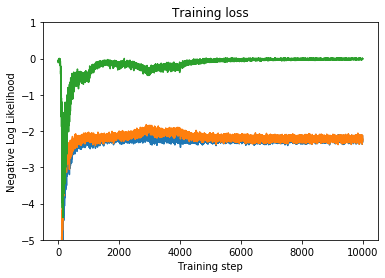

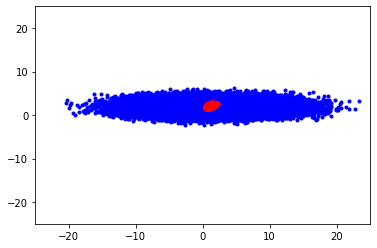

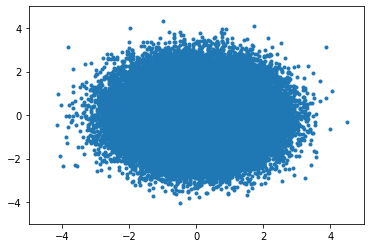

In [10]:
train_vae(data1, use_scalar_sigma=True)

# Dataset 2, diagonal standard deviation

/home/david/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


train epoch:    1  temp:   0.200  loss:   1.495  p(x|z):  -1.214  p(z|x):  -1.405
train epoch:    2  temp:   0.400  loss:   1.595  p(x|z):  -1.082  p(z|x):  -1.280
train epoch:    3  temp:   0.600  loss:   1.713  p(x|z):  -1.022  p(z|x):  -1.152
train epoch:    4  temp:   0.800  loss:   2.095  p(x|z):  -1.137  p(z|x):  -1.198
train epoch:    5  temp:   1.000  loss:   2.244  p(x|z):  -1.245  p(z|x):  -0.999
train epoch:    6  temp:   1.000  loss:   2.286  p(x|z):  -1.326  p(z|x):  -0.960
train epoch:    7  temp:   1.000  loss:   2.198  p(x|z):  -1.310  p(z|x):  -0.888
train epoch:    8  temp:   1.000  loss:   2.234  p(x|z):  -1.338  p(z|x):  -0.896
train epoch:    9  temp:   1.000  loss:   2.177  p(x|z):  -1.362  p(z|x):  -0.816
train epoch:   10  temp:   1.000  loss:   2.183  p(x|z):  -1.420  p(z|x):  -0.763
x mean:  [0.9903847 1.9881011]
x std:  [3.6051059 3.5822015]
z mean:  [0.01970207 0.00144004]
z std:  [1.0130589 1.0113542]


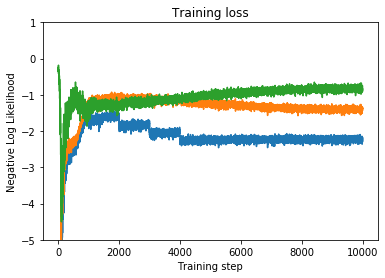

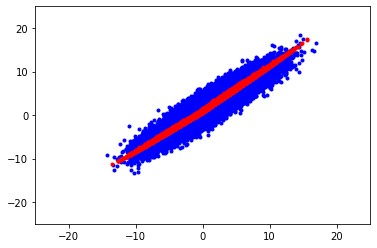

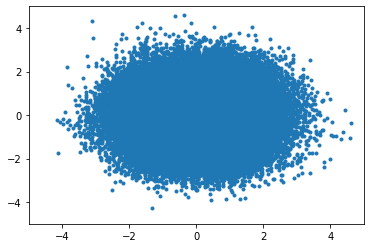

In [11]:
train_vae(data2, use_scalar_sigma=False)

# Dataset 2, scalar standard deviation

/home/david/anaconda3/lib/python3.7/site-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


train epoch:    1  temp:   0.200  loss:   2.738  p(x|z):  -2.493  p(z|x):  -1.227
train epoch:    2  temp:   0.400  loss:   2.524  p(x|z):  -2.348  p(z|x):  -0.441
train epoch:    3  temp:   0.600  loss:   2.082  p(x|z):  -1.395  p(z|x):  -1.144
train epoch:    4  temp:   0.800  loss:   2.164  p(x|z):  -1.442  p(z|x):  -0.902
train epoch:    5  temp:   1.000  loss:   2.272  p(x|z):  -1.559  p(z|x):  -0.713
train epoch:    6  temp:   1.000  loss:   2.335  p(x|z):  -1.553  p(z|x):  -0.782
train epoch:    7  temp:   1.000  loss:   2.387  p(x|z):  -1.617  p(z|x):  -0.770
train epoch:    8  temp:   1.000  loss:   2.511  p(x|z):  -1.588  p(z|x):  -0.922
train epoch:    9  temp:   1.000  loss:   2.215  p(x|z):  -1.427  p(z|x):  -0.787
train epoch:   10  temp:   1.000  loss:   2.348  p(x|z):  -1.571  p(z|x):  -0.777
x mean:  [0.9095536 1.9524677]
x std:  [3.3525283 3.3334548]
z mean:  [0.00911299 0.0367981 ]
z std:  [1.0295522  0.97875905]


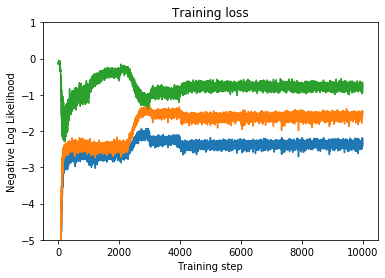

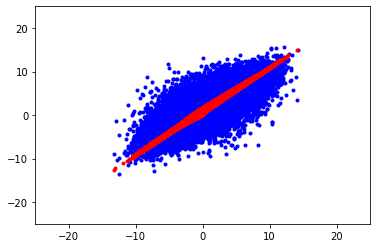

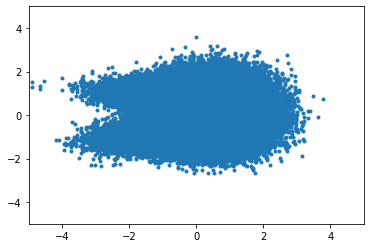

In [12]:
train_vae(data2, use_scalar_sigma=True)